In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bmi_topography import Topography
from landlab import RasterModelGrid, imshow_grid, imshowhs_grid
from landlab.components import BedrockLandslider, PriorityFloodFlowRouter
from landlab.io import read_esri_ascii

In [ ]:
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter

In [2]:
topo = Topography(
    dem_type="SRTMGL1",
    south=39.93,
    north=40.0,
    west=-105.33,
    east=-105.26,
    output_format="AAIGrid",
    cache_dir="DEMData//",
)

/opt/tljh/user/envs/csdms/lib/python3.12/site-packages/bmi_topography/api_key.py:48: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


In [3]:
fname = topo.fetch()
print(fname)

/home/jupyter-usd3@txstate.edu/repos/ESPIn_Floods_2025/DEMData/SRTMGL1_39.93_-105.33_40.0_-105.26.asc


In [4]:
dem = topo.load()
print(dem)

<xarray.DataArray 'SRTMGL1' (band: 1, y: 252, x: 252)> Size: 254kB
[63504 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 2kB 40.0 40.0 40.0 40.0 ... 39.93 39.93 39.93 39.93
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    -32768
    scale_factor:  1.0
    add_offset:    0.0
    units:         unknown


/opt/tljh/user/envs/csdms/lib/python3.12/site-packages/bmi_topography/topography.py:183: UserWarning: A CRS cannot be identified for these data. Grid units will be set to 'unknown'.
  warnings.warn(


/tmp/ipykernel_726933/1787709006.py:2: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation")


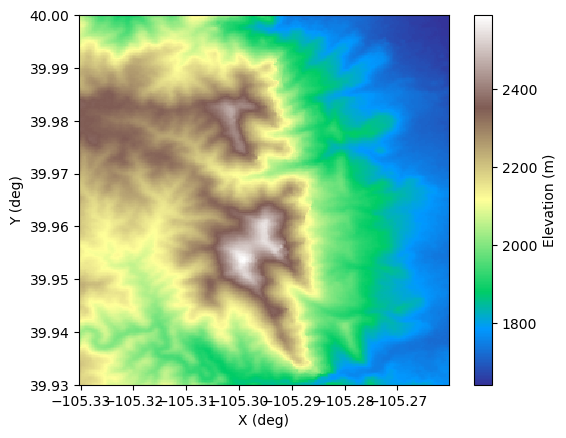

In [5]:
# Read DEM as Landlab grid
grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation")

grid_geog.imshow(
    "topographic__elevation",
    cmap="terrain",
    grid_units=("deg", "deg"),
    colorbar_label="Elevation (m)",
)

In [6]:
# make a new grid with RasterModelGrid, use the dimensions of grid_geog
grid = RasterModelGrid(grid_geog.shape, xy_spacing=30.0)
grid.at_node["topographic__elevation"] = grid_geog.at_node["topographic__elevation"]

<Axes: xlabel='Easting', ylabel='Northing'>

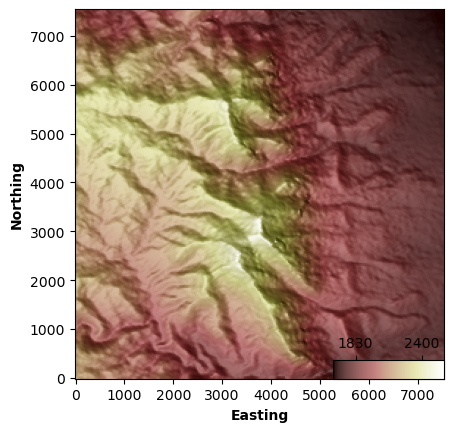

In [7]:
# Plot this one with imshowhs_grid
imshowhs_grid(grid, "topographic__elevation")

In [8]:
# These are plotting functions


def plotting(
    grid, topo=True, DA=True, hill_DA=False, flow_metric="D8", hill_flow_metric="Quinn"
):
    if topo:
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap="terrain",
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA:
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap="terrain",
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

    if hill_DA:
        # Plot second instance of drainage_area (hill_drainage_area)
        grid.at_node["hill_drainage_area"][grid.at_node["hill_drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        # plotDA = np.log10(grid.at_node["hill_drainage_area"] * 111e3 * 111e3)
        # plt.figure()
        # imshow_grid(grid, plotDA,grid_units=("m", "m"), var_name="Elevation (m)", cmap='terrain')

        plt.figure()
        plot_type = "Drape1"
        # plot_type='Drape2'
        drape1 = np.log10(grid.at_node["hill_drainage_area"])
        thres_drape1 = None
        alpha = 0.5
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap="terrain",
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=10,
            cbar_tick_size=10,
            var_name="$log^{10} DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = hill_flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

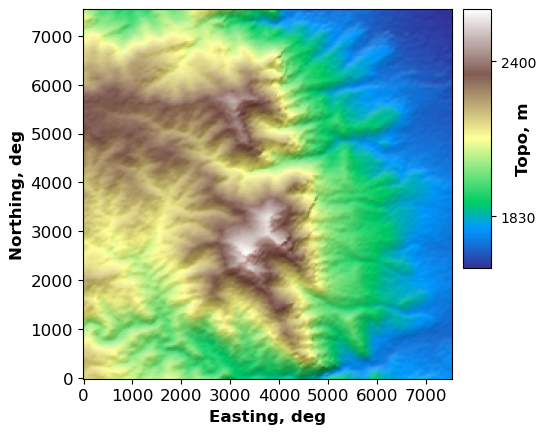

In [9]:
# Plot output products
plotting(grid, DA=False)

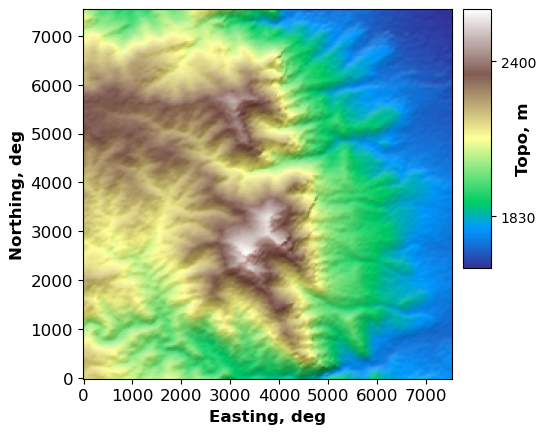

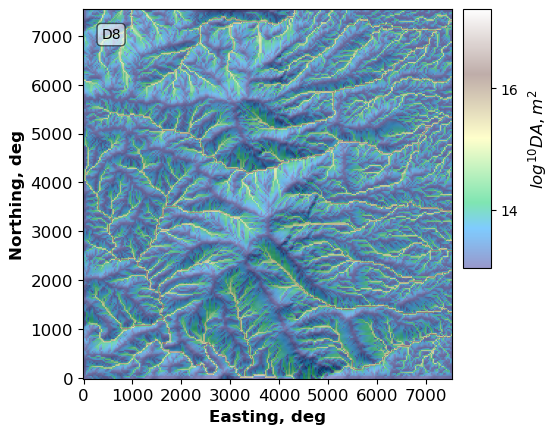

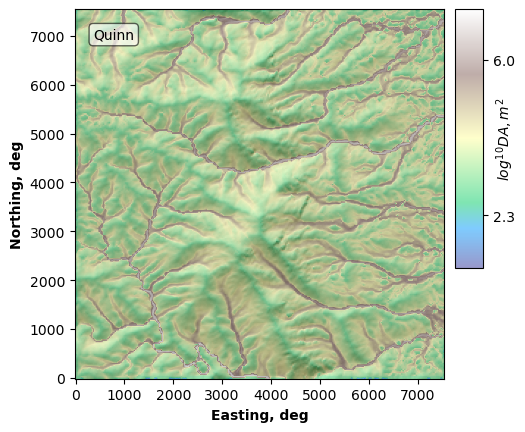

In [10]:
# Here, we only calculate flow directions using the first instance of the flow accumulator
flow_metric = "D8"
fa_PF = PriorityFloodFlowRouter(
    grid,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

fa_PF.run_one_step()

# Plot output products
plotting(grid, hill_DA=True)

In [11]:
from landlab.components import FlowDirectorSteepest, SedDepEroder, OverlandFlow, ErosionDeposition 
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid

In [12]:
#SedDepEroder.input_var_names

In [13]:
#PriorityFloodFlowRouter.output_var_names

In [14]:
#grid.at_node['flood_status_code']

In [15]:
#thresh_shields = np.arange(1, grid.number_of_nodes + 1, dtype=float)
#thresh_shields /= 100.0

#sde1 = SedDepEroder(
    #grid,
    #threshold_shear_stress=100.0,
    #Qc="MPM",
    #Dchar=None,
    #set_threshold_from_Dchar=False,
    #set_Dchar_from_threshold=True,
    #threshold_Shields=thresh_shields,
    #g=9.81,
#)

In [16]:
#thresh_shields

In [17]:
#np.max(thresh_shields)

## Everthing under here is overland flow and we do not need because it is not sediment
grid.add_zeros("surface_water__depth", at="node")
of = OverlandFlow(grid, mannings_n=0.03, steep_slopes=True)

elapsed_time = 0.0
model_run_time = 86400.0
of = OverlandFlow(
    grid, steep_slopes=True, rainfall_intensity=1.38889 * (10**-6)
)  # m/s

while elapsed_time < model_run_time:
    of.dt = of.calc_time_step()  # Adaptive time step

    if elapsed_time < (storm_duration):
        of.rainfall_intensity = rainfall_mmhr * (2.777778 * 10**-7)
    else:
        of.rainfall_intensity = 0.0

    of.overland_flow()

    grid.at_node["surface_water__discharge"] = of.discharge_mapper(grid.at_link["surface_water__discharge"], convert_to_volume=True
    )

    elapsed_time += of.dt

hydrograph_time = []
discharge_at_outlet = []

hydrograph_time.append(elapsed_time / 3600.0)  # convert seconds to hours
discharge_at_outlet.append(
    np.abs(of.q[outlet_link]) * rmg.dx
)  # append discharge in m^3/s

plt.plot(hydrograph_time, discharge_at_outlet)
plt.ylabel("Time (hr)")
plt.xlabel("Discharge, (cms)")
plt.title("Outlet Hydrograph, Rainfall: 5 mm/hr in 2 hr")

imshow_grid(
    rmg,
    "surface_water__depth",
    plot_name="Water depth at time = 2 hr",
    var_name="Water Depth",
    var_units="m",
    grid_units=("m", "m"),
    cmap="Blues",
)

In [18]:
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

ed = ErosionDeposition(
    grid,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

In [19]:
# Parameters
nrows = 41
ncols = 41
dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 120000.0  # duration of run, yr
dt = 100.0  # time-step duration, yr
plot_every = 40000.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])
for i in range(1, nsteps + 1):
    # route flow
    fa_PF.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

KeyboardInterrupt: 

In [20]:
# Parameters
nrows = 41
ncols = 41
dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 120000.0  # duration of run, yr
dt = 100.0  # time-step duration, yr
plot_every = 40000.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])
from tqdm import trange
for i in trange(1, 5):
    # route flow
    fa_PF.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


In [21]:
    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every